In [73]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree

In [74]:
ruta_archivo = '/Users/macronald/U Central/Tesis Maestria Calidad/Insumos/df_TS.csv'
df = pd.read_csv(ruta_archivo)
df_check = df

In [75]:
import pandas as pd

# Asumiendo df_check es tu DataFrame
df_check['DateTime'] = pd.to_datetime(df_check['DateTime'])

# Extracción de características de fecha y hora
df_check['year'] = df_check['DateTime'].dt.year
df_check['month'] = df_check['DateTime'].dt.month
df_check['day'] = df_check['DateTime'].dt.day
df_check['hour'] = df_check['DateTime'].dt.hour
df_check['weekday'] = df_check['DateTime'].dt.weekday

# Eliminar la columna original de DateTime ya que hemos extraído la información necesaria
df_prepared = df_check.set_index(['DateTime'])
#df_prepared = df_check.drop(['DateTime'], axis=1)

In [76]:
df_prepared = df_prepared[df_prepared['Estacion']=='Tunal']
df_prepared = df_prepared.drop(['Estacion'], axis=1)
df_prepared

,ICA,year,month,day,hour,weekday
DateTime,,,,,,
2020-01-01 01:00:00,97.0,2020,1,1,1,2
2020-01-01 02:00:00,104.0,2020,1,1,2,2
2020-01-01 03:00:00,151.0,2020,1,1,3,2
2020-01-01 04:00:00,128.0,2020,1,1,4,2
2020-01-01 05:00:00,124.0,2020,1,1,5,2
...,...,...,...,...,...,...
2024-02-05 20:00:00,64.0,2024,2,5,20,0
2024-02-05 21:00:00,56.0,2024,2,5,21,0
2024-02-05 22:00:00,78.0,2024,2,5,22,0


In [78]:
# Crear características basadas en valores pasados (puedes ajustar el número según sea necesario)
for i in range(1, 49):  # 48 horas equivalen a 2 días
    df_prepared[f'ICA_lag_{i}'] = df_prepared['ICA'].shift(i)

# Desplazar la columna ICA dos días hacia adelante
df_prepared['ICA_target'] = df_prepared['ICA'].shift(-48)  # Cambia 48 por el número correcto de intervalos por día en tus datos

# Eliminar las filas con valores NaN resultantes de los desplazamientos
df_prepared = df_prepared.dropna()

# Dividir los datos en características y etiquetas
X = df_prepared.drop(['ICA', 'ICA_target'], axis=1)
y = df_prepared['ICA_target']
print(X)
# Dividir los datos en conjuntos de entrenamiento y prueba
split_index = int(len(X) * 0.9)  # El 90% para entrenamiento
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

                     year  month  day  hour  weekday  ICA_lag_1  ICA_lag_2  \
DateTime                                                                     
2020-01-05 01:00:00  2020      1    5     1        6       42.0       58.0   
2020-01-05 02:00:00  2020      1    5     2        6       49.0       42.0   
2020-01-05 03:00:00  2020      1    5     3        6       39.0       49.0   
2020-01-05 04:00:00  2020      1    5     4        6       49.0       39.0   
2020-01-05 05:00:00  2020      1    5     5        6       26.0       49.0   
...                   ...    ...  ...   ...      ...        ...        ...   
2024-02-01 20:00:00  2024      2    1    20        3       89.0       85.0   
2024-02-01 21:00:00  2024      2    1    21        3       76.0       89.0   
2024-02-01 22:00:00  2024      2    1    22        3       62.0       76.0   
2024-02-01 23:00:00  2024      2    1    23        3       78.0       62.0   
2024-02-01 23:59:00  2024      2    1    23        3       64.0 

/var/folders/z_/5fqft4xs5wlfmvf3mjrfqzcc0000gn/T/ipykernel_79293/927836220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prepared[f'ICA_lag_{i}'] = df_prepared['ICA'].shift(i)
/var/folders/z_/5fqft4xs5wlfmvf3mjrfqzcc0000gn/T/ipykernel_79293/927836220.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prepared['ICA_target'] = df_prepared['ICA'].shift(-48)  # Cambia 48 por el número correcto de intervalos por día en tus datos


In [46]:
import xgboost as xgb

# Convertir los conjuntos de datos en DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros del modelo XGBoost
params = {
    'max_depth': 6,
    'eta': 0.05,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Entrenar el modelo
num_boost_round = 100
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_boost_round, evals)


[0]	train-rmse:27.27195	test-rmse:27.83352
[1]	train-rmse:26.93974	test-rmse:27.65510
[2]	train-rmse:26.63825	test-rmse:27.48140
[3]	train-rmse:26.36195	test-rmse:27.37624
[4]	train-rmse:26.09574	test-rmse:27.22976
[5]	train-rmse:25.85730	test-rmse:27.16135
[6]	train-rmse:25.63461	test-rmse:27.09085
[7]	train-rmse:25.42843	test-rmse:27.00590
[8]	train-rmse:25.23742	test-rmse:26.93414
[9]	train-rmse:25.05152	test-rmse:26.83876
[10]	train-rmse:24.84612	test-rmse:26.74244
[11]	train-rmse:24.67295	test-rmse:26.65859
[12]	train-rmse:24.49743	test-rmse:26.57645
[13]	train-rmse:24.32895	test-rmse:26.49960
[14]	train-rmse:24.18932	test-rmse:26.45213
[15]	train-rmse:24.04232	test-rmse:26.39147
[16]	train-rmse:23.91264	test-rmse:26.34592
[17]	train-rmse:23.80052	test-rmse:26.30783
[18]	train-rmse:23.65474	test-rmse:26.26882
[19]	train-rmse:23.55104	test-rmse:26.22426
[20]	train-rmse:23.42255	test-rmse:26.19032
[21]	train-rmse:23.32441	test-rmse:26.17390
[22]	train-rmse:23.21143	test-rmse:26.1571

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[35]	train-rmse:22.21828	test-rmse:25.94146
[36]	train-rmse:22.15098	test-rmse:25.96449
[37]	train-rmse:22.07378	test-rmse:25.96102
[38]	train-rmse:22.02064	test-rmse:25.95307
[39]	train-rmse:21.95982	test-rmse:25.93598
[40]	train-rmse:21.88013	test-rmse:25.92535
[41]	train-rmse:21.81059	test-rmse:25.94634
[42]	train-rmse:21.76149	test-rmse:25.97799
[43]	train-rmse:21.69012	test-rmse:25.96179
[44]	train-rmse:21.64267	test-rmse:25.97501
[45]	train-rmse:21.57904	test-rmse:25.95041
[46]	train-rmse:21.51943	test-rmse:25.98032
[47]	train-rmse:21.47873	test-rmse:25.98438
[48]	train-rmse:21.40952	test-rmse:25.99560
[49]	train-rmse:21.36542	test-rmse:25.98589
[50]	train-rmse:21.30289	test-rmse:26.01770
[51]	train-rmse:21.26135	test-rmse:26.01144
[52]	train-rmse:21.20836	test-rmse:26.01702
[53]	train-rmse:21.16415	test-rmse:26.00848
[54]	train-rmse:21.12882	test-rmse:26.00693
[55]	train-rmse:21.07554	test-rmse:25.99712
[56]	train-rmse:21.04087	test-rmse:25.98532
[57]	train-rmse:21.00060	test-rm

In [47]:
# Realizar predicciones
y_pred = model.predict(dtest)

# Calcular y mostrar el error de predicción
mse = mean_squared_error(y_test, y_pred)
# Cálculo del RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Multiplicar por 100 para obtener el porcentaje

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')


MSE: 679.1783467830858
RMSE: 26.0610503775862
MAPE: 54.038233244228685%


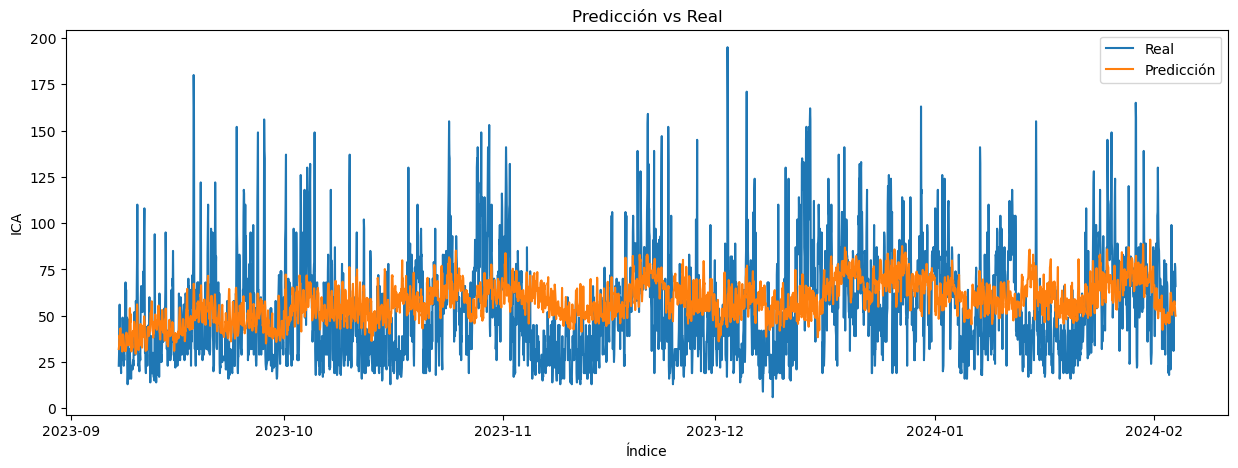

In [48]:
import matplotlib.pyplot as plt

# Visualizar las predicciones vs los valores reales
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred, label='Predicción')
plt.title('Predicción vs Real')
plt.xlabel('Índice')
plt.ylabel('ICA')
plt.legend()
plt.show()


In [58]:
ruta_archivo = '/Users/macronald/U Central/Tesis Maestria Calidad/Insumos/df_TS.csv'
df = pd.read_csv(ruta_archivo)
df_check = df

In [61]:
import pandas as pd
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def prepare_data(df, estacion):
    """
    Prepara los datos para el entrenamiento y la evaluación del modelo.
    """
    df_prepared = df[df['Estacion'] == estacion].copy()
    df_prepared = df_prepared.set_index(['DateTime'])
    df_prepared = df_prepared.drop(['Estacion'], axis=1)
    
    # Crear características basadas en valores pasados
    for i in range(1, 49):  # 48 horas equivalen a 2 días
        df_prepared[f'ICA_lag_{i}'] = df_prepared['ICA'].shift(i)
    
    # Desplazar la columna ICA dos días hacia adelante
    df_prepared['ICA_target'] = df_prepared['ICA'].shift(-48)
    df_prepared = df_prepared.dropna()  # Eliminar las filas con valores NaN
    
    # Dividir los datos en características y etiquetas
    X = df_prepared.drop(['ICA', 'ICA_target'], axis=1)
    y = df_prepared['ICA_target']
    
    return X, y

def train_model(X_train, y_train, X_test, y_test, params, num_boost_round, evals):
    """
    Entrena el modelo XGBoost y realiza predicciones en el conjunto de prueba.
    """
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, num_boost_round, evals)
    y_pred = model.predict(dtest)
    return y_test, y_pred,model

def evaluate_model(y_test, y_pred):
    """
    Evalúa el rendimiento del modelo utilizando MSE, RMSE y MAPE.
    """
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    return mse, rmse, mape

def main(df_check, params, num_boost_round, evals):
    """
    Proceso principal para entrenar y evaluar un modelo para cada estación.
    """
    # Inicializar una lista para almacenar los resultados temporales
    temp_results = []  # Usaremos una lista para recolectar DataFrames temporales
    
    for estacion in df_check['Estacion'].unique():
        X, y = prepare_data(df_check, estacion)
        split_index = int(len(X) * 0.9)
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
        y_test, y_pred,model = train_model(X_train, y_train, X_test, y_test, params, num_boost_round, evals)
        save_model(model,f'/Users/macronald/U Central/Tesis Maestria Calidad/Scripts/Modelos/{estacion}.pkl')
        mse, rmse, mape = evaluate_model(y_test, y_pred)

        # En lugar de append, creamos un DataFrame y lo añadimos a la lista
        temp_results.append(pd.DataFrame({'Estacion': [estacion], 'MSE': [mse], 'RMSE': [rmse], 'MAPE': [mape]}))

    # Concatenar todos los DataFrames de la lista en uno solo
    results = pd.concat(temp_results, ignore_index=True)
    return results

#Almacenar Modelo
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


# Definición de parámetros del modelo
params = {
    'max_depth': 6,
    'eta': 0.05,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Extracción de características de fecha y hora del DataFrame original
df_check['DateTime'] = pd.to_datetime(df_check['DateTime'])
df_check['year'] = df_check['DateTime'].dt.year
df_check['month'] = df_check['DateTime'].dt.month
df_check['day'] = df_check['DateTime'].dt.day
df_check['hour'] = df_check['DateTime'].dt.hour
df_check['weekday'] = df_check['DateTime'].dt.weekday

# Ejecutar el proceso principal
results = main(df_check, params, 100, [(dtrain, 'train'), (dtest, 'test')])
print(results)


[0]	train-rmse:28.08805	test-rmse:29.74294
[1]	train-rmse:27.79727	test-rmse:29.56121
[2]	train-rmse:27.52768	test-rmse:29.40043
[3]	train-rmse:27.28359	test-rmse:29.23866
[4]	train-rmse:27.05390	test-rmse:29.09380
[5]	train-rmse:26.83535	test-rmse:28.96191
[6]	train-rmse:26.64200	test-rmse:28.83681
[7]	train-rmse:26.47317	test-rmse:28.71753
[8]	train-rmse:26.30215	test-rmse:28.60343
[9]	train-rmse:26.15119	test-rmse:28.49888
[10]	train-rmse:26.01142	test-rmse:28.42433
[11]	train-rmse:25.89497	test-rmse:28.35598
[12]	train-rmse:25.76721	test-rmse:28.27177
[13]	train-rmse:25.65521	test-rmse:28.20125
[14]	train-rmse:25.54244	test-rmse:28.09663
[15]	train-rmse:25.44959	test-rmse:28.03135
[16]	train-rmse:25.35039	test-rmse:27.94722
[17]	train-rmse:25.26926	test-rmse:27.88927
[18]	train-rmse:25.18820	test-rmse:27.82403
[19]	train-rmse:25.11411	test-rmse:27.75149
[20]	train-rmse:25.04180	test-rmse:27.69125
[21]	train-rmse:24.97221	test-rmse:27.61769
[22]	train-rmse:24.90016	test-rmse:27.5642

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:24.33147	test-rmse:27.14992
[33]	train-rmse:24.29056	test-rmse:27.11369
[34]	train-rmse:24.24788	test-rmse:27.07346
[35]	train-rmse:24.20365	test-rmse:27.03763
[36]	train-rmse:24.16430	test-rmse:27.00141
[37]	train-rmse:24.12715	test-rmse:26.97510
[38]	train-rmse:24.07961	test-rmse:26.93024
[39]	train-rmse:24.04289	test-rmse:26.88497
[40]	train-rmse:24.01677	test-rmse:26.86433
[41]	train-rmse:23.98198	test-rmse:26.83641
[42]	train-rmse:23.95195	test-rmse:26.80910
[43]	train-rmse:23.91827	test-rmse:26.79956
[44]	train-rmse:23.88294	test-rmse:26.78716
[45]	train-rmse:23.84290	test-rmse:26.75243
[46]	train-rmse:23.82128	test-rmse:26.73561
[47]	train-rmse:23.79534	test-rmse:26.73254
[48]	train-rmse:23.76382	test-rmse:26.71768
[49]	train-rmse:23.72399	test-rmse:26.70693
[50]	train-rmse:23.70207	test-rmse:26.69146
[51]	train-rmse:23.67496	test-rmse:26.66565
[52]	train-rmse:23.65426	test-rmse:26.67547
[53]	train-rmse:23.63288	test-rmse:26.65595
[54]	train-rmse:23.60959	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[29]	train-rmse:29.29244	test-rmse:26.02544
[30]	train-rmse:29.29558	test-rmse:25.99823
[31]	train-rmse:29.25543	test-rmse:25.98264
[32]	train-rmse:29.22056	test-rmse:25.97237
[33]	train-rmse:29.15799	test-rmse:25.95112
[34]	train-rmse:29.17793	test-rmse:25.94135
[35]	train-rmse:29.10058	test-rmse:25.91818
[36]	train-rmse:29.07977	test-rmse:25.92451
[37]	train-rmse:29.04997	test-rmse:25.92520
[38]	train-rmse:28.97458	test-rmse:25.90962
[39]	train-rmse:29.00398	test-rmse:25.88696
[40]	train-rmse:28.96012	test-rmse:25.89062
[41]	train-rmse:28.89991	test-rmse:25.88372
[42]	train-rmse:28.95616	test-rmse:25.86785
[43]	train-rmse:28.93444	test-rmse:25.85462
[44]	train-rmse:28.93694	test-rmse:25.85097
[45]	train-rmse:28.88914	test-rmse:25.83957
[46]	train-rmse:28.83447	test-rmse:25.82397
[47]	train-rmse:28.81355	test-rmse:25.82038
[48]	train-rmse:28.76893	test-rmse:25.82430
[49]	train-rmse:28.73064	test-rmse:25.82717
[50]	train-rmse:28.76330	test-rmse:25.82630
[51]	train-rmse:28.74968	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[34]	train-rmse:24.03976	test-rmse:26.21476
[35]	train-rmse:23.99778	test-rmse:26.21065
[36]	train-rmse:23.97998	test-rmse:26.21072
[37]	train-rmse:23.94884	test-rmse:26.18087
[38]	train-rmse:23.91892	test-rmse:26.19856
[39]	train-rmse:23.89278	test-rmse:26.19932
[40]	train-rmse:23.86083	test-rmse:26.17843
[41]	train-rmse:23.84375	test-rmse:26.17077
[42]	train-rmse:23.82253	test-rmse:26.16394
[43]	train-rmse:23.79735	test-rmse:26.16559
[44]	train-rmse:23.78173	test-rmse:26.16217
[45]	train-rmse:23.75217	test-rmse:26.14344
[46]	train-rmse:23.73888	test-rmse:26.14268
[47]	train-rmse:23.72474	test-rmse:26.13363
[48]	train-rmse:23.71381	test-rmse:26.13808
[49]	train-rmse:23.68665	test-rmse:26.12973
[50]	train-rmse:23.68152	test-rmse:26.13496
[51]	train-rmse:23.65640	test-rmse:26.12852
[52]	train-rmse:23.62420	test-rmse:26.11513
[53]	train-rmse:23.61880	test-rmse:26.12654
[54]	train-rmse:23.61106	test-rmse:26.12879
[55]	train-rmse:23.60187	test-rmse:26.13800
[56]	train-rmse:23.58523	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[35]	train-rmse:24.56800	test-rmse:27.35032
[36]	train-rmse:24.53130	test-rmse:27.32793
[37]	train-rmse:24.50241	test-rmse:27.28738
[38]	train-rmse:24.46978	test-rmse:27.26881
[39]	train-rmse:24.42034	test-rmse:27.21809
[40]	train-rmse:24.39326	test-rmse:27.20536
[41]	train-rmse:24.35771	test-rmse:27.17354
[42]	train-rmse:24.33461	test-rmse:27.16628
[43]	train-rmse:24.31175	test-rmse:27.15662
[44]	train-rmse:24.28202	test-rmse:27.12736
[45]	train-rmse:24.26367	test-rmse:27.10296
[46]	train-rmse:24.22610	test-rmse:27.05663
[47]	train-rmse:24.21040	test-rmse:27.08121
[48]	train-rmse:24.19100	test-rmse:27.07123
[49]	train-rmse:24.16663	test-rmse:27.06324
[50]	train-rmse:24.15220	test-rmse:27.05526
[51]	train-rmse:24.13627	test-rmse:27.02357
[52]	train-rmse:24.12134	test-rmse:27.02054
[53]	train-rmse:24.08914	test-rmse:26.98358
[54]	train-rmse:24.07323	test-rmse:26.97875
[55]	train-rmse:24.06219	test-rmse:26.97859
[56]	train-rmse:24.03135	test-rmse:26.97164
[57]	train-rmse:24.01907	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:25.99354	test-rmse:27.08799
[34]	train-rmse:25.96102	test-rmse:27.10321
[35]	train-rmse:25.91791	test-rmse:27.10241
[36]	train-rmse:25.87987	test-rmse:27.10352
[37]	train-rmse:25.84581	test-rmse:27.10098
[38]	train-rmse:25.84547	test-rmse:27.10123
[39]	train-rmse:25.82552	test-rmse:27.09560
[40]	train-rmse:25.79937	test-rmse:27.09177
[41]	train-rmse:25.78852	test-rmse:27.10881
[42]	train-rmse:25.76627	test-rmse:27.11284
[43]	train-rmse:25.74702	test-rmse:27.15867
[44]	train-rmse:25.75496	test-rmse:27.17513
[45]	train-rmse:25.73525	test-rmse:27.16993
[46]	train-rmse:25.70284	test-rmse:27.15874
[47]	train-rmse:25.69299	test-rmse:27.16232
[48]	train-rmse:25.68235	test-rmse:27.15287
[49]	train-rmse:25.64327	test-rmse:27.19304
[50]	train-rmse:25.62205	test-rmse:27.19000
[51]	train-rmse:25.61930	test-rmse:27.20310
[52]	train-rmse:25.58662	test-rmse:27.24626
[53]	train-rmse:25.56970	test-rmse:27.26081
[54]	train-rmse:25.56667	test-rmse:27.25026
[55]	train-rmse:25.55599	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[35]	train-rmse:24.05445	test-rmse:26.86892
[36]	train-rmse:24.01054	test-rmse:26.84209
[37]	train-rmse:23.98204	test-rmse:26.83588
[38]	train-rmse:23.95220	test-rmse:26.80703
[39]	train-rmse:23.92726	test-rmse:26.79064
[40]	train-rmse:23.88763	test-rmse:26.77317
[41]	train-rmse:23.85542	test-rmse:26.75775
[42]	train-rmse:23.83442	test-rmse:26.73479
[43]	train-rmse:23.79862	test-rmse:26.73226
[44]	train-rmse:23.76449	test-rmse:26.71135
[45]	train-rmse:23.73913	test-rmse:26.70981
[46]	train-rmse:23.72273	test-rmse:26.68732
[47]	train-rmse:23.69488	test-rmse:26.67345
[48]	train-rmse:23.66329	test-rmse:26.67533
[49]	train-rmse:23.64617	test-rmse:26.65777
[50]	train-rmse:23.61803	test-rmse:26.64069
[51]	train-rmse:23.58126	test-rmse:26.61736
[52]	train-rmse:23.55671	test-rmse:26.59780
[53]	train-rmse:23.52044	test-rmse:26.61134
[54]	train-rmse:23.49249	test-rmse:26.59311
[55]	train-rmse:23.46833	test-rmse:26.59276
[56]	train-rmse:23.44650	test-rmse:26.58116
[57]	train-rmse:23.43119	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[34]	train-rmse:24.74398	test-rmse:27.50425
[35]	train-rmse:24.69727	test-rmse:27.46171
[36]	train-rmse:24.66307	test-rmse:27.42811
[37]	train-rmse:24.62695	test-rmse:27.39894
[38]	train-rmse:24.58995	test-rmse:27.37103
[39]	train-rmse:24.55935	test-rmse:27.32050
[40]	train-rmse:24.52890	test-rmse:27.28406
[41]	train-rmse:24.49045	test-rmse:27.21754
[42]	train-rmse:24.46101	test-rmse:27.19246
[43]	train-rmse:24.45117	test-rmse:27.17122
[44]	train-rmse:24.43818	test-rmse:27.14476
[45]	train-rmse:24.41384	test-rmse:27.12646
[46]	train-rmse:24.40399	test-rmse:27.12951
[47]	train-rmse:24.37408	test-rmse:27.10219
[48]	train-rmse:24.36141	test-rmse:27.08141
[49]	train-rmse:24.35672	test-rmse:27.06411
[50]	train-rmse:24.32973	test-rmse:27.03746
[51]	train-rmse:24.31085	test-rmse:27.02677
[52]	train-rmse:24.28854	test-rmse:27.00038
[53]	train-rmse:24.25771	test-rmse:27.00054
[54]	train-rmse:24.24328	test-rmse:27.00648
[55]	train-rmse:24.22216	test-rmse:27.02724
[56]	train-rmse:24.20569	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:24.42646	test-rmse:26.19400
[33]	train-rmse:24.39457	test-rmse:26.16825
[34]	train-rmse:24.37128	test-rmse:26.12960
[35]	train-rmse:24.36816	test-rmse:26.11758
[36]	train-rmse:24.34205	test-rmse:26.09789
[37]	train-rmse:24.31466	test-rmse:26.08432
[38]	train-rmse:24.30019	test-rmse:26.07640
[39]	train-rmse:24.28312	test-rmse:26.06458
[40]	train-rmse:24.26723	test-rmse:26.05774
[41]	train-rmse:24.24186	test-rmse:26.06250
[42]	train-rmse:24.23430	test-rmse:26.05865
[43]	train-rmse:24.22183	test-rmse:26.05579
[44]	train-rmse:24.21396	test-rmse:26.03371
[45]	train-rmse:24.18205	test-rmse:26.01888
[46]	train-rmse:24.15711	test-rmse:26.02398
[47]	train-rmse:24.16144	test-rmse:26.02600
[48]	train-rmse:24.15803	test-rmse:26.03376
[49]	train-rmse:24.15710	test-rmse:26.02360
[50]	train-rmse:24.13645	test-rmse:26.01688
[51]	train-rmse:24.13864	test-rmse:26.01908
[52]	train-rmse:24.10564	test-rmse:26.01930
[53]	train-rmse:24.09703	test-rmse:26.02794
[54]	train-rmse:24.06322	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:24.85818	test-rmse:27.15807
[34]	train-rmse:24.84388	test-rmse:27.18074
[35]	train-rmse:24.85793	test-rmse:27.21253
[36]	train-rmse:24.83410	test-rmse:27.18755
[37]	train-rmse:24.82295	test-rmse:27.17098
[38]	train-rmse:24.84010	test-rmse:27.22413
[39]	train-rmse:24.81612	test-rmse:27.23428
[40]	train-rmse:24.84110	test-rmse:27.30624
[41]	train-rmse:24.82485	test-rmse:27.30369
[42]	train-rmse:24.83783	test-rmse:27.30981
[43]	train-rmse:24.82504	test-rmse:27.32265
[44]	train-rmse:24.84741	test-rmse:27.35104
[45]	train-rmse:24.82218	test-rmse:27.35610
[46]	train-rmse:24.84834	test-rmse:27.38789
[47]	train-rmse:24.87080	test-rmse:27.42785
[48]	train-rmse:24.83964	test-rmse:27.42970
[49]	train-rmse:24.86703	test-rmse:27.46796
[50]	train-rmse:24.85030	test-rmse:27.45187
[51]	train-rmse:24.83843	test-rmse:27.45482
[52]	train-rmse:24.85298	test-rmse:27.48219
[53]	train-rmse:24.83578	test-rmse:27.47729
[54]	train-rmse:24.82044	test-rmse:27.48169
[55]	train-rmse:24.84134	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:25.11234	test-rmse:27.64869
[34]	train-rmse:25.07845	test-rmse:27.60730
[35]	train-rmse:25.04279	test-rmse:27.57934
[36]	train-rmse:25.01176	test-rmse:27.55152
[37]	train-rmse:24.98469	test-rmse:27.52644
[38]	train-rmse:24.96735	test-rmse:27.49538
[39]	train-rmse:24.94084	test-rmse:27.47926
[40]	train-rmse:24.91787	test-rmse:27.43305
[41]	train-rmse:24.90023	test-rmse:27.40584
[42]	train-rmse:24.88893	test-rmse:27.37357
[43]	train-rmse:24.88104	test-rmse:27.36445
[44]	train-rmse:24.84166	test-rmse:27.31633
[45]	train-rmse:24.83684	test-rmse:27.32298
[46]	train-rmse:24.80834	test-rmse:27.30012
[47]	train-rmse:24.80465	test-rmse:27.31433
[48]	train-rmse:24.77343	test-rmse:27.27705
[49]	train-rmse:24.76166	test-rmse:27.27627
[50]	train-rmse:24.74743	test-rmse:27.29369
[51]	train-rmse:24.74808	test-rmse:27.30032
[52]	train-rmse:24.70838	test-rmse:27.28887
[53]	train-rmse:24.69764	test-rmse:27.29245
[54]	train-rmse:24.70573	test-rmse:27.29849
[55]	train-rmse:24.69624	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[34]	train-rmse:24.00444	test-rmse:26.69336
[35]	train-rmse:23.96651	test-rmse:26.66987
[36]	train-rmse:23.94095	test-rmse:26.65361
[37]	train-rmse:23.91763	test-rmse:26.63737
[38]	train-rmse:23.89292	test-rmse:26.62362
[39]	train-rmse:23.85178	test-rmse:26.59899
[40]	train-rmse:23.82859	test-rmse:26.57671
[41]	train-rmse:23.79937	test-rmse:26.55271
[42]	train-rmse:23.76245	test-rmse:26.54236
[43]	train-rmse:23.74374	test-rmse:26.53097
[44]	train-rmse:23.72557	test-rmse:26.51629
[45]	train-rmse:23.70392	test-rmse:26.49773
[46]	train-rmse:23.68837	test-rmse:26.48909
[47]	train-rmse:23.66575	test-rmse:26.48114
[48]	train-rmse:23.62690	test-rmse:26.47270
[49]	train-rmse:23.60917	test-rmse:26.46409
[50]	train-rmse:23.59150	test-rmse:26.45326
[51]	train-rmse:23.57016	test-rmse:26.43869
[52]	train-rmse:23.55299	test-rmse:26.42075
[53]	train-rmse:23.53605	test-rmse:26.41119
[54]	train-rmse:23.52424	test-rmse:26.40959
[55]	train-rmse:23.49944	test-rmse:26.39296
[56]	train-rmse:23.48704	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:22.33822	test-rmse:25.97184
[34]	train-rmse:22.27681	test-rmse:25.96237
[35]	train-rmse:22.21828	test-rmse:25.94146
[36]	train-rmse:22.15098	test-rmse:25.96449
[37]	train-rmse:22.07378	test-rmse:25.96102
[38]	train-rmse:22.02064	test-rmse:25.95307
[39]	train-rmse:21.95982	test-rmse:25.93598
[40]	train-rmse:21.88013	test-rmse:25.92535
[41]	train-rmse:21.81059	test-rmse:25.94634
[42]	train-rmse:21.76149	test-rmse:25.97799
[43]	train-rmse:21.69012	test-rmse:25.96179
[44]	train-rmse:21.64267	test-rmse:25.97501
[45]	train-rmse:21.57904	test-rmse:25.95041
[46]	train-rmse:21.51943	test-rmse:25.98032
[47]	train-rmse:21.47873	test-rmse:25.98438
[48]	train-rmse:21.40952	test-rmse:25.99560
[49]	train-rmse:21.36542	test-rmse:25.98589
[50]	train-rmse:21.30289	test-rmse:26.01770
[51]	train-rmse:21.26135	test-rmse:26.01144
[52]	train-rmse:21.20836	test-rmse:26.01702
[53]	train-rmse:21.16415	test-rmse:26.00848
[54]	train-rmse:21.12882	test-rmse:26.00693
[55]	train-rmse:21.07554	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[34]	train-rmse:25.65046	test-rmse:29.71002
[35]	train-rmse:25.62503	test-rmse:29.68207
[36]	train-rmse:25.59218	test-rmse:29.64182
[37]	train-rmse:25.55937	test-rmse:29.59999
[38]	train-rmse:25.53198	test-rmse:29.56652
[39]	train-rmse:25.51085	test-rmse:29.58433
[40]	train-rmse:25.47088	test-rmse:29.60544
[41]	train-rmse:25.43438	test-rmse:29.57195
[42]	train-rmse:25.40804	test-rmse:29.59543
[43]	train-rmse:25.37997	test-rmse:29.55806
[44]	train-rmse:25.34589	test-rmse:29.58188
[45]	train-rmse:25.31852	test-rmse:29.55895
[46]	train-rmse:25.28392	test-rmse:29.56450
[47]	train-rmse:25.27732	test-rmse:29.55768
[48]	train-rmse:25.25859	test-rmse:29.53521
[49]	train-rmse:25.24131	test-rmse:29.51399
[50]	train-rmse:25.22286	test-rmse:29.49658
[51]	train-rmse:25.19783	test-rmse:29.48419
[52]	train-rmse:25.17540	test-rmse:29.46604
[53]	train-rmse:25.15252	test-rmse:29.42192
[54]	train-rmse:25.13067	test-rmse:29.40385
[55]	train-rmse:25.12473	test-rmse:29.39406
[56]	train-rmse:25.10912	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[35]	train-rmse:24.32966	test-rmse:26.71517
[36]	train-rmse:24.28901	test-rmse:26.68208
[37]	train-rmse:24.26812	test-rmse:26.67419
[38]	train-rmse:24.22705	test-rmse:26.66022
[39]	train-rmse:24.22581	test-rmse:26.64909
[40]	train-rmse:24.21925	test-rmse:26.64782
[41]	train-rmse:24.17987	test-rmse:26.64612
[42]	train-rmse:24.18039	test-rmse:26.65567
[43]	train-rmse:24.18029	test-rmse:26.66047
[44]	train-rmse:24.14416	test-rmse:26.65821
[45]	train-rmse:24.15047	test-rmse:26.67801
[46]	train-rmse:24.13291	test-rmse:26.67217
[47]	train-rmse:24.10121	test-rmse:26.67920
[48]	train-rmse:24.10565	test-rmse:26.69288
[49]	train-rmse:24.08649	test-rmse:26.69767
[50]	train-rmse:24.05881	test-rmse:26.69877
[51]	train-rmse:24.06262	test-rmse:26.71402
[52]	train-rmse:24.06587	test-rmse:26.73067
[53]	train-rmse:24.03792	test-rmse:26.74959
[54]	train-rmse:24.02750	test-rmse:26.75347
[55]	train-rmse:24.00853	test-rmse:26.77976
[56]	train-rmse:24.01561	test-rmse:26.81630
[57]	train-rmse:24.00133	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[36]	train-rmse:24.53938	test-rmse:27.01846
[37]	train-rmse:24.51075	test-rmse:27.00848
[38]	train-rmse:24.47495	test-rmse:26.97276
[39]	train-rmse:24.45085	test-rmse:26.94954
[40]	train-rmse:24.42930	test-rmse:26.93390
[41]	train-rmse:24.40680	test-rmse:26.92870
[42]	train-rmse:24.39701	test-rmse:26.93090
[43]	train-rmse:24.37030	test-rmse:26.92546
[44]	train-rmse:24.35031	test-rmse:26.91793
[45]	train-rmse:24.33402	test-rmse:26.89856
[46]	train-rmse:24.31384	test-rmse:26.89520
[47]	train-rmse:24.30235	test-rmse:26.90588
[48]	train-rmse:24.28920	test-rmse:26.87865
[49]	train-rmse:24.25862	test-rmse:26.86640
[50]	train-rmse:24.24818	test-rmse:26.87810
[51]	train-rmse:24.22549	test-rmse:26.88063
[52]	train-rmse:24.21018	test-rmse:26.88071
[53]	train-rmse:24.20249	test-rmse:26.88958
[54]	train-rmse:24.19511	test-rmse:26.91013
[55]	train-rmse:24.18040	test-rmse:26.90996
[56]	train-rmse:24.16742	test-rmse:26.90336
[57]	train-rmse:24.14897	test-rmse:26.89641
[58]	train-rmse:24.13218	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[34]	train-rmse:24.56143	test-rmse:26.65180
[35]	train-rmse:24.53474	test-rmse:26.63681
[36]	train-rmse:24.51496	test-rmse:26.65083
[37]	train-rmse:24.48655	test-rmse:26.62607
[38]	train-rmse:24.46665	test-rmse:26.61557
[39]	train-rmse:24.45455	test-rmse:26.62229
[40]	train-rmse:24.43253	test-rmse:26.60858
[41]	train-rmse:24.39598	test-rmse:26.60575
[42]	train-rmse:24.37350	test-rmse:26.64039
[43]	train-rmse:24.35689	test-rmse:26.63703
[44]	train-rmse:24.32945	test-rmse:26.64008
[45]	train-rmse:24.31165	test-rmse:26.63345
[46]	train-rmse:24.30154	test-rmse:26.62104
[47]	train-rmse:24.28614	test-rmse:26.64255
[48]	train-rmse:24.26738	test-rmse:26.63871
[49]	train-rmse:24.25449	test-rmse:26.63254
[50]	train-rmse:24.24715	test-rmse:26.63762
[51]	train-rmse:24.24105	test-rmse:26.64358
[52]	train-rmse:24.22965	test-rmse:26.63554
[53]	train-rmse:24.22316	test-rmse:26.64159
[54]	train-rmse:24.20964	test-rmse:26.63725
[55]	train-rmse:24.20272	test-rmse:26.64225
[56]	train-rmse:24.19841	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:24.61569	test-rmse:28.17884
[34]	train-rmse:24.58391	test-rmse:28.16635
[35]	train-rmse:24.56142	test-rmse:28.16739
[36]	train-rmse:24.52401	test-rmse:28.34138
[37]	train-rmse:24.49377	test-rmse:28.44073
[38]	train-rmse:24.47694	test-rmse:28.56976
[39]	train-rmse:24.44611	test-rmse:28.57228
[40]	train-rmse:24.42774	test-rmse:28.58188
[41]	train-rmse:24.41227	test-rmse:28.57067
[42]	train-rmse:24.39934	test-rmse:28.58083
[43]	train-rmse:24.37439	test-rmse:28.60004
[44]	train-rmse:24.36232	test-rmse:28.61669
[45]	train-rmse:24.32887	test-rmse:28.62450
[46]	train-rmse:24.32097	test-rmse:28.59850
[47]	train-rmse:24.30682	test-rmse:28.59360
[48]	train-rmse:24.30160	test-rmse:28.59247
[49]	train-rmse:24.29053	test-rmse:28.59961
[50]	train-rmse:24.28823	test-rmse:28.56291
[51]	train-rmse:24.27377	test-rmse:28.55463
[52]	train-rmse:24.26495	test-rmse:28.55354
[53]	train-rmse:24.24151	test-rmse:28.57882
[54]	train-rmse:24.24613	test-rmse:28.63239
[55]	train-rmse:24.22361	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[36]	train-rmse:28.21221	test-rmse:30.29373
[37]	train-rmse:28.21009	test-rmse:30.26010
[38]	train-rmse:28.17117	test-rmse:30.21928
[39]	train-rmse:28.17316	test-rmse:30.18983
[40]	train-rmse:28.16555	test-rmse:30.17889
[41]	train-rmse:28.11295	test-rmse:30.12199
[42]	train-rmse:28.11434	test-rmse:30.09340
[43]	train-rmse:28.11374	test-rmse:30.05731
[44]	train-rmse:28.06033	test-rmse:30.00834
[45]	train-rmse:28.02793	test-rmse:29.97712
[46]	train-rmse:28.01832	test-rmse:29.94479
[47]	train-rmse:27.98196	test-rmse:29.92731
[48]	train-rmse:27.98524	test-rmse:29.89663
[49]	train-rmse:27.98528	test-rmse:29.87248
[50]	train-rmse:27.96688	test-rmse:29.85577
[51]	train-rmse:27.95435	test-rmse:29.83659
[52]	train-rmse:27.93301	test-rmse:29.82487
[53]	train-rmse:27.93719	test-rmse:29.81870
[54]	train-rmse:27.92493	test-rmse:29.80714
[55]	train-rmse:27.89752	test-rmse:29.77642
[56]	train-rmse:27.87993	test-rmse:29.75764
[57]	train-rmse:27.88305	test-rmse:29.73769
[58]	train-rmse:27.87581	test-rm

/Users/macronald/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[35]	train-rmse:27.29695	test-rmse:28.32296
[36]	train-rmse:27.27866	test-rmse:28.32783
[37]	train-rmse:27.30815	test-rmse:28.36690
[38]	train-rmse:27.29648	test-rmse:28.37879
[39]	train-rmse:27.29998	test-rmse:28.41901
[40]	train-rmse:27.26654	test-rmse:28.41506
[41]	train-rmse:27.25585	test-rmse:28.42579
[42]	train-rmse:27.28896	test-rmse:28.40510
[43]	train-rmse:27.29437	test-rmse:28.41013
[44]	train-rmse:27.29975	test-rmse:28.42569
[45]	train-rmse:27.29864	test-rmse:28.40982
[46]	train-rmse:27.30337	test-rmse:28.42315
[47]	train-rmse:27.32115	test-rmse:28.42608
[48]	train-rmse:27.30581	test-rmse:28.43635
[49]	train-rmse:27.29951	test-rmse:28.44413
[50]	train-rmse:27.29505	test-rmse:28.45247
[51]	train-rmse:27.30109	test-rmse:28.44086
[52]	train-rmse:27.29181	test-rmse:28.45640
[53]	train-rmse:27.28173	test-rmse:28.46275
[54]	train-rmse:27.27353	test-rmse:28.44753
[55]	train-rmse:27.27090	test-rmse:28.45011
[56]	train-rmse:27.27254	test-rmse:28.46721
[57]	train-rmse:27.23842	test-rm

In [54]:
results

,Estacion,MSE,RMSE,MAPE
0,AltoRendimiento,554.289950,23.543363,54.038233
1,CarvajalSevillana,1148.331135,33.887035,54.038233
2,Fontibon,496.495978,22.282190,54.038233
3,Guaymaral,400.191876,20.004796,54.038233
4,Kennedy,625.959361,25.019180,54.038233
5,LasFerias,505.169767,22.475982,54.038233
6,MinAmbiente,562.363002,23.714194,54.038233
7,MovilSeptima,527.533020,22.968087,54.038233
8,PuenteAranda,485.408492,22.031988,54.038233
9,SanCristobal,518.871096,22.778742,54.038233


In [55]:
# Ordenar por RMSE de menor a mayor (mejor rendimiento a peor)
sorted_by_rmse = results.sort_values(by='RMSE', ascending=True)
print("Ordenado por RMSE (mejor a peor):")
sorted_by_rmse

Ordenado por RMSE (mejor a peor):


,Estacion,MSE,RMSE,MAPE
12,Usaquen,374.235266,19.345161,54.038233
10,Suba,384.183356,19.600596,54.038233
3,Guaymaral,400.191876,20.004796,54.038233
15,Bolivia,422.282366,20.549510,54.038233
17,Colina,441.880245,21.020948,54.038233
14,Usme,469.753178,21.673790,54.038233
8,PuenteAranda,485.408492,22.031988,54.038233
2,Fontibon,496.495978,22.282190,54.038233
5,LasFerias,505.169767,22.475982,54.038233
9,SanCristobal,518.871096,22.778742,54.038233


In [72]:
import pandas as pd
from datetime import datetime, timedelta

def generate_date_features(estacion):
    # Obtener la fecha actual
    current_date = datetime.now()

    # Generar rango de fechas para los próximos cinco días
    date_range = pd.date_range(start=current_date, periods=6)

    # Crear DataFrame con el rango de fechas
    df = pd.DataFrame(date_range, columns=['date'])

    # Extraer características de las fechas
    df['DateTime'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df['weekday'] = df['date'].dt.weekday
    df['Estacion'] = estacion 

    return df
def prepare_future(df, estacion):
    """
    Prepara los datos para el entrenamiento y la evaluación del modelo.
    """
    df_prepared = df[df['Estacion'] == estacion].copy()
    df_prepared = df_prepared.set_index(['DateTime'])
    df_prepared = df_prepared.drop(['Estacion'], axis=1)
    
    # Crear características basadas en valores pasados
    for i in range(1, 49):  # 48 horas equivalen a 2 días
        df_prepared[f'ICA_lag_{i}'] = df_prepared['ICA'].shift(i)
    
    # Desplazar la columna ICA dos días hacia adelante
    df_prepared['ICA_target'] = df_prepared['ICA'].shift(-48)
    df_prepared = df_prepared.dropna()  # Eliminar las filas con valores NaN
    
    # Dividir los datos en características y etiquetas
    X = df_prepared.drop(['ICA', 'ICA_target'], axis=1)
    y = df_prepared['ICA_target']
    
    return X, y


df_date = generate_date_features('Suba')
df_date

,date,DateTime,year,month,day,hour,weekday,Estacion
0,2024-02-25 22:48:00.166321,2024-02-25 22:48:00.166321,2024,2,25,22,6,Suba
1,2024-02-26 22:48:00.166321,2024-02-26 22:48:00.166321,2024,2,26,22,0,Suba
2,2024-02-27 22:48:00.166321,2024-02-27 22:48:00.166321,2024,2,27,22,1,Suba
3,2024-02-28 22:48:00.166321,2024-02-28 22:48:00.166321,2024,2,28,22,2,Suba
4,2024-02-29 22:48:00.166321,2024-02-29 22:48:00.166321,2024,2,29,22,3,Suba
5,2024-03-01 22:48:00.166321,2024-03-01 22:48:00.166321,2024,3,1,22,4,Suba


In [71]:
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

model = load_model('/Users/macronald/U Central/Tesis Maestria Calidad/Scripts/Modelos/Suba.pkl')
X, y = prepare_data(df_date, 'Suba')
split_index = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
dtest = xgb.DMatrix(X_test, label=y_test)
y = model.predict(dtest)
y

KeyError: 'ICA'